# Tutorial: Computer Vision ML

## Typical CNN Architecture
![CNN](data/images/17_cnn_architecture.png)

Explain Figure

### Feature Learning
 - Convolution Operation
     - Stride
     - Padding
     - Max Pooling
     - ReLU
     
### Classification
 - Fully Connected Layer
 - Softmax
 
### Forward Pass and Backward Pass

## Image classification

Using MNIST dataset.
MNIST (Modified National Institute of Standards and Technology) dataset is like the hello-world in computer vision. The dataset was
created way back in the late 90s. The official description states,

"The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting."

In [1]:
#Import Libraries


from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable


In [2]:
args={}
kwargs={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=True

In [3]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)

/home/smittal/anaconda3/envs/aiml_tutorials/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630742027/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()  #Dropout
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #Convolutional Layer/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        #Convolutional Layer/Dropout/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        #Fully Connected Layer/Activation
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        #Fully Connected Layer/Activation
        x = self.fc2(x)
        #Softmax gets probabilities. 
        return F.log_softmax(x, dim=1)

In [44]:

def train(epoch):
    tot_loss = 0
    model.train()
    print(len(train_loader))
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: NA'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))
            

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False) #.data[0] # sum up batch loss
        #print(test_loss)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        #print(pred)
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [45]:
model = Net()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    print(epoch)
    train(epoch)
    test()

1
60
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310921
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.293151
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.293205
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.282909
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.267855
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.255391


/home/smittal/anaconda3/envs/aiml_tutorials/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Test set: Average loss: 2.2213, Accuracy: 2815/10000 (28%)

2
60
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.245358
Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.217484
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.173050
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.156676
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.115368
Train Epoch: 2 [50000/60000 (83%)]	Loss: 2.024882

Test set: Average loss: 1.8219, Accuracy: 6243/10000 (62%)

3
60
Train Epoch: 3 [0/60000 (0%)]	Loss: 1.949923
Train Epoch: 3 [10000/60000 (17%)]	Loss: 1.822837
Train Epoch: 3 [20000/60000 (33%)]	Loss: 1.749572
Train Epoch: 3 [30000/60000 (50%)]	Loss: 1.582351
Train Epoch: 3 [40000/60000 (67%)]	Loss: 1.499750
Train Epoch: 3 [50000/60000 (83%)]	Loss: 1.388973

Test set: Average loss: 0.8969, Accuracy: 8287/10000 (83%)

4
60
Train Epoch: 4 [0/60000 (0%)]	Loss: 1.316513
Train Epoch: 4 [10000/60000 (17%)]	Loss: 1.253339
Train Epoch: 4 [20000/60000 (33%)]	Loss: 1.188148
Train Epoch: 4 [30000/60000 (50%)]	Loss: 1.099021
Train Epoch: 4 [4

/home/smittal/anaconda3/envs/aiml_tutorials/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


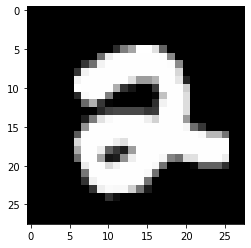

tensor(2, device='cuda:0')


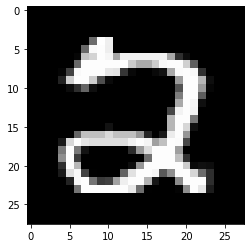

tensor(2, device='cuda:0')


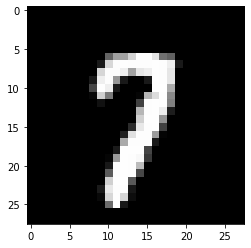

tensor(7, device='cuda:0')


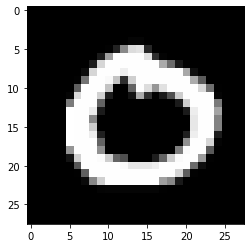

tensor(0, device='cuda:0')

Test set: Average loss: 0.2458, Accuracy: 9298/10000 (93%)



In [46]:
import matplotlib.pyplot as plt 
# Plots are plotted inside the notebooks, 'inline'
%matplotlib inline 

model.eval()
test_loss = 0
correct = 0
pred = None
dataset = None
for data, target in test_loader:
    dataset = data
    if args['cuda']:
        data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    output = model(data)
    
    test_loss += F.nll_loss(output, target, size_average=False) #.data[0] # sum up batch loss
    #print(test_loss)
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    
    correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

for i in range(4):
    plt.imshow(dataset[i].numpy().reshape((28,28)), cmap='gray')
    plt.show()
    print(pred[i].data[0])
test_loss /= len(test_loader.dataset)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
